# Grover implementation with 5 qubits and 1 marked state

In [44]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

ibmqfactory.load_account:WARNING:2021-09-18 15:49:17,439: Credentials are already in use. The existing account in the session will be replaced.


In [45]:
print("Available backends:")
provider.backends()


Available backends:


[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_santiago') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_bogota') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_mps') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_extended_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_m

In [46]:
from qiskit.providers.ibmq import least_busy

large_enough_devices = provider.backends(filters=lambda x: x.configuration().n_qubits > 3 and not x.configuration().simulator)
backend = least_busy(large_enough_devices)
print("The best backend is " + backend.name())


The best backend is ibmq_quito


In [73]:
backend = provider.get_backend('ibmq_lima')

In [74]:
backend

<IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q', group='open', project='main')>

Here I code Grover's Algorithm with 5 qubits

In [75]:
#def initialization in superposition
def initialization(qc, qubits):
    for qubit in qubits:
        qc.h(qubit)
    return qc

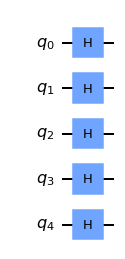

In [76]:
example = QuantumCircuit(5)
example_ = initialization(example, range(5))
example_.draw('mpl')

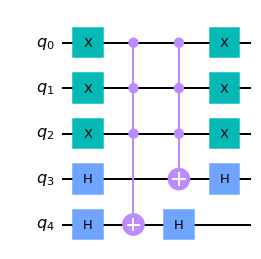

In [77]:
#def oracle marking state [0,0,.....1]
# 1 state marked
num_q = 5

from numpy import pi
qc = QuantumCircuit(num_q)

for i in range(num_q -2):
    qc.x(i)
qc.h(num_q -1)
qc.mct(list(range(num_q -2)), num_q -1)  # multi-controlled-toffoli
qc.h(num_q -2)
#o = [0, 1, 2, 4]
qc.mct(list(range(num_q -2)), num_q -2)
#qc.mct(o, num_q -2)
qc.h(num_q -2)
#temp
#qc.h(num_q -2)
#qc.mct(list(range(num_q -2)), num_q -2)  # multi-controlled-toffoli
#qc.h(num_q -2)
#fine temp

qc.h(num_q -1)
for i in range(num_q -2):
    qc.x(i)

oracle_ = qc.to_gate()
oracle_.name = "Oracle"
qc.draw('mpl')


In [78]:
#diffuser
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "V"
    return U_s

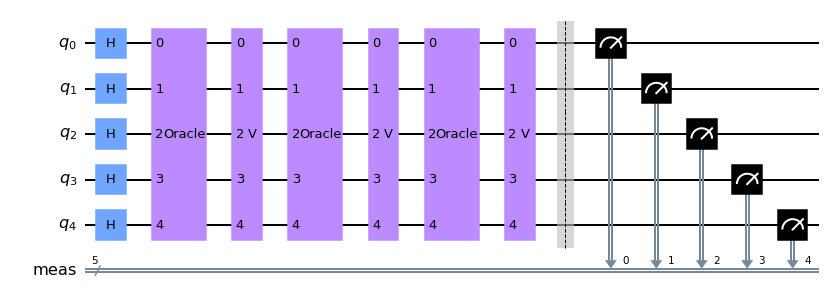

In [79]:
num_qubits = 5
grover_circ = QuantumCircuit(num_qubits)
grover_circ = initialization(grover_circ, range(num_qubits))
for i in range(3):
    grover_circ.append(oracle_, range(num_qubits))
    grover_circ.append(diffuser(num_qubits), range(num_qubits))
grover_circ.measure_all()
grover_circ.draw()

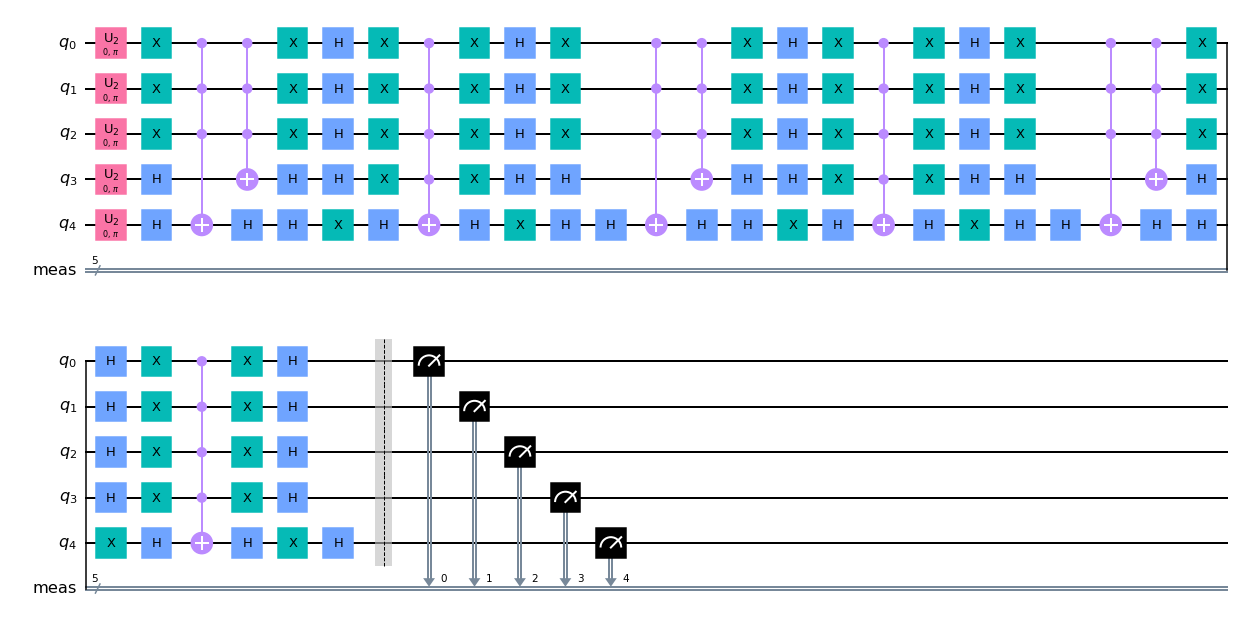

In [80]:
grover_circ__ = grover_circ.decompose()
grover_circ__.draw()

# Evaluation on classical simulator

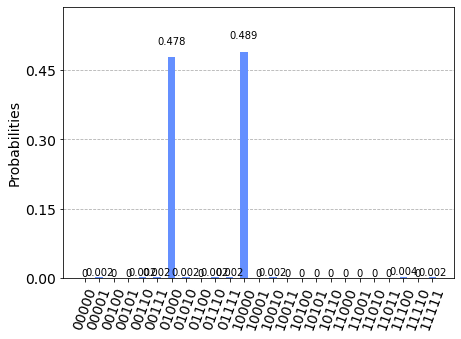

In [81]:
aer_sim = Aer.get_backend('aer_simulator')
transpiled_grover_circuit = transpile(grover_circ, aer_sim)
qobj = assemble(transpiled_grover_circuit)
results = aer_sim.run(qobj).result()
counts = results.get_counts()
plot_histogram(counts)

In [82]:
from qiskit.tools.monitor import job_monitor
device = backend
transpiled_grover_circuit = transpile(grover_circ, device, optimization_level=3)
job = device.run(transpiled_grover_circuit, shots = 8000)
job_monitor(job, interval=2)

Job Status: job has successfully run


# Results on Quantum Hardware
We can see that the noise in the quantum hardware, considering also the lenght of the circuit given the 5 loops, makes impossible to find the correct solution. This problem could be solved simply considering more desired results, then reducing the loops.

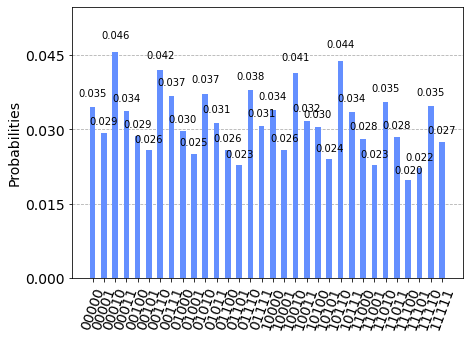

In [83]:
results = job.result()
answer = results.get_counts(grover_circ)
plot_histogram(answer)